![](gradient-descent.svg)

<img 
  src="/images/jupyter-view-notebook.svg"
  href="https://www.github.com/msburns24/website/posts/stochastic-gradient-descent/index.ipynb"
  width="128"
/>

Gradient descent is one of the most fundamental tools in data science, as it
opens the door to models that don't have a closed-form solution. Even more,
it sets the foundation for more complex optimization algorithms like momentum
and Adam.

An issue that arises with gradient descent is the time it takes to calculate
the gradients for larger datasets. In such cases, we may look to algorithms
like stochastic gradient descent to speed up the training. Effectively, we are
sacrificing some accuracy in the direction of the gradient for faster
calculation time of the gradients.

One question that comes to mind for me: Is stochastic gradient descent worth
the tradeoff of speed for randomness? How much better does it perform?

Let's test this ourselves. We can use the standard Iris dataset, with some
additional modifications that we'll get to in later sections.

![](iris-setosa.jpg)

## Setup

To start, we'll import the needed modules and load the dataset:

In [173]:
# Load modules
from __future__ import annotations
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup type hints
from typing import Optional
from numpy.typing import NDArray

# Load data
df = sns.load_dataset('iris')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Data Preparation

To make the experiment cleaner, I am going to make a few changes to the
dataset. As a good general practice, I like to create helper functions for each
step of my data preparation. This helps with debugging and makes the whole
process much smoother, plus we can create a data preparation workflow and apply
all steps at once.

First, I want to apply **standard scaling.** This is typical, but will improve
the speed of our training -- no need to put any further odds against us. This
is done by effectively converting our raw data into z-scores:

$$ x_{scaled} = \frac{x - \mu_x}{\sigma_x} $$

In [128]:
def standard_scale(data: pd.Series) -> pd.Series:
    return (data - data.mean()) / data.std()

Next, I want to use **one-hot encoding** on the output labels. This means our
model will be a "setosa predictor", as opposed to a predictor for all 3
species.

In [129]:
def one_hot_encode(data: pd.Series, target: str) -> pd.Series:
    return data.eq(target).astype(int)

Finally, I wan to apply **bootstrap resampling** on the whole dataset. The
standard Iris dataset only has 150 samples, which is trivially fast to compute
the gradient. To make the impact of gradient calculations clearer, I'll use
bootstrap resampling to expand our dataset to a **new size of 100,000**.

In [130]:
def bootstrap_resample(df: pd.DataFrame, size: int) -> pd.DataFrame:
    return df.sample(size, replace=True).reset_index(drop=True)

As a final step, we can separate our data into the feature matrix `X` and
label vector `y`:

In [ ]:
def separate_xy(df: pd.DataFrame, target_column: str) -> tuple[NDArray, ...]:
    X = df.drop(target_column, axis=1).values
    y = df[target_column].values
    return X, y

With all the preparation steps ready, we can create a full workflow to
transform our raw data into a dataset ready for experimentation:

In [132]:
def prepare_data(df: pd.DataFrame, size: int) -> tuple[NDArray, ...]:
    df = df.copy()   # Preserve raw data
    target_column = 'species'
    target_species = 'setosa'

    for column in df.columns:
        if column == target_column:
            df[column] = one_hot_encode(df[column], target_species)
        else:
            df[column] = standard_scale(df[column])

    df = bootstrap_resample(df, size=size)
    X, y = separate_xy(df, target_column)
    return X, y

## Logistic Regression Model

![](sigmoid.jpg)

The term *logistic regression* primarily comes from the logistic function,
also called the **sigmoid function**, $\sigma(z)$:

$$
\sigma (z) = \frac{1}{1 + \exp{(-z)}}
$$

This S-shaped curve provides a maps any real number to a value in between 0
and 1. Mathematically, we can express this as:

$$
\sigma : \mathbb{R} \rightarrow \left[ 0, 1 \right]
$$

This function has a huge benefit: If we used linear regression to model
probabilities, we may end up with probabilities like $p = 527.68$ or $p = -1$,
since linear regression puts no limit on the bounds of the output. If we pass
the linear model through the sigmoid function, however, we can ensure that all
output values are between 0 and 1, which we can then interpret as a
probability.

In [133]:
def sigmoid(z: NDArray) -> NDArray:
    return 1 / (1 + np.exp(-z))

To keep our classification model simple, we will use a Linear Regression model,
which builds on the linear regression model by passing it though the sigmoid
function. More precisely:

$$
p(y = 1 | x) = \sigma ( x^T \theta )
$$

where $p(y = 1 | x)$ is the probability of class 1 given the input features
$x$, and $\theta$ is the vector of coefficients. 

Note that the coefficients also includes a bias (intercept) term as the first
element, so we typically pad matrix $X$ with ones in the first column, allowing
us to simply perform matrix multiplication to get our predictions.

In [134]:
def predict(X: NDArray, theta: NDArray) -> NDArray:
    '''
    Parameters
    ----------
    X : NDArray
        Input features, shape: `(n, d)`
    theta : NDArray
        Coefficients, shape: `(d + 1,)`

    Returns
    -------
    p : NDArray
        Probabilities, shape: `(n,)`
    '''
    X_aug = np.c_[np.ones((X.shape[0], 1)), X]
    z = X_aug @ theta.reshape(-1, 1)
    p = sigmoid(z)
    return p.flatten()

## Cross-Entropy Loss

One of the most common losses used in logistic regression is cross-entropy:

$$
L(\theta) = - \frac{1}{n} \sum_{i=1}^n \bigl(
    y_i \log{p_i} + (1 - y_i) \log{(1 - p_i)}
\bigr)
$$

In [135]:
def cross_entropy(y: NDArray, p: NDArray) -> np.number:
    '''
    Parameters
    ----------
    y : NDArray
        Shape: `(n,)`
    p : NDArray
        Shape: `(n,)`
    '''
    y, p = y.flatten(), p.flatten()
    entropy = - y * np.log(p) - (1 - y) * np.log(1 - p)
    return np.mean(entropy)

For both batch and stochastic gradient descent, we will need the gradient of
the loss function:

$$
\nabla L(\theta) = - \frac{1}{n} \sum_{i=1}^n \bigl(
    (y_i - p_i) \; x_i
\bigr)
$$

In [136]:
def gradient(X: NDArray, y: NDArray, p: NDArray) -> np.number:
    '''
    Parameters
    ----------
    X : NDArray
        Input features, shape: `(n, d)`
    y : NDArray
        Output labels, shape: `(n,)`
    p : NDArray
        Predictions, shape: `(n,)`

    Returns
    -------
    grad : NDArray
        Gradients, shape: `(d + 1,)`
    '''
    X_aug = np.c_[np.ones((X.shape[0], 1)), X]
    diff = (y - p).reshape(-1, 1)
    grad = np.mean(- X_aug * diff, axis=0)
    return grad

## Batch Gradient Descent

![](gradient-descent.png)

While linear regression can be performed using a single, closed-form expression,
we aren't as lucky with many other machine learning models. The best case is
using an iterative training approach like gradient descent. 

We start by initializing a random vector for $\theta$, then update iteratively:

$$
\theta^{(\tau + 1)} = \theta^{(\tau)} - \eta \nabla L(\theta^{(\tau)})
$$

Where $\tau$ is the step index, $\theta^{(\tau)}$ is the coefficient vector at
step $\tau$, and $\eta$ is the learning rate. While we have the option to make
$\eta$ a function of $\tau$--i.e. allowing larger or smaller steps at each 
iteration--we will keep it constant here for simplicity.

::: {.callout-note}
The standard version of gradient descent is also called "batch" gradient
descent. This naming is a little confusing, as it seems to imply that the
gradient is calculated in batches, when it is actually calculated for all
samples at once. A better way to think of this naming is that the gradient is
calculated in a single "batch" for each iteration.
:::

In [137]:
def batch_gradient_descent(
        X: NDArray,
        y: NDArray,
        epochs: int,
        learning_rate: float=0.05,
) -> tuple[NDArray, NDArray]:
    '''
    Perform batch gradient descent over a given number of epochs.

    Parameters
    ----------
    X : NDArray
        Input features, shape `(n, d)`
    y : NDArray
        Output labels, shape `(n, 1)`
    epochs : int
        The number of training epochs to perform.
    learning_rate : float, default: 0.05
        The learning rate to use for gradient descent.

    Returns
    -------
    theta : NDArray
        The bias and coefficients, shape `(d + 1,)`
    losses : NDArray
        The history of training losses
    '''
    theta = np.random.random(size=(X.shape[1] + 1,))
    losses = np.zeros((epochs, ))

    for epoch in range(epochs):
        p = predict(X, theta)
        losses[epoch] = cross_entropy(y, p)
        grad = gradient(X, y, p)
        theta = theta - learning_rate * grad

    return theta, losses

![](stochastic-gradient-descent.png)

## Stochastic Gradient Descent

As is our objective to test, there are often situations where calculating the
entire $\nabla L(\theta)$ isn't practical due to the time it takes to
calculate. In these cases, we can use a modified version of gradient descent
called stochastic gradient descent. Instead of using the entire training set
to calculate the gradient, we take a smaller batch of samples and use those
instead. 

If we define an indexing set $\mathbb{I} = \{ 1, 2, \dots, n \}$, then we can
take a batch of samples $B \subset \mathbb{I}$, where $\left| B \right| < n$.
Our gradient equation then becomes:

$$
\nabla L(\theta) = - \frac{1}{\left| B \right|} \sum_{i \in B} \bigl(
    (y_i - p_i) \; x_i
\bigr)
$$

In [138]:
def get_batched_data(
        X: NDArray,
        y: NDArray,
        size: int
) -> tuple[NDArray, NDArray]:
    '''
    Parameters
    ----------
    X : NDArray
        The input features, shape: `(n, d)`
    y : NDArray
        The output labels, shape: `(n, )`
    size : int
        The batch size
    '''
    full_indexes = np.arange(X.shape[0])
    batch_indexes = np.random.choice(full_indexes, size=size)
    return X[batch_indexes], y[batch_indexes]

Outside of using batches instead of the full batch, our process for stochastic
gradient descent is almost identical to batched gradient descent. However, to
ensure we're training to the same level between batch and stochastic
gradient descent, we'll add an additional, optional parameter for early
stopping, measured by the training loss. If we provide this parameter,
stop training and return the parameters. Otherwise, we'll stop when the 
number of epochs is reached.

In [165]:
def stochastic_gradient_descent(
        X: NDArray,
        y: NDArray,
        epochs: int=50,
        learning_rate: float=0.05,
        batch_size: int=32,
        early_stopping_loss: Optional[float]=None
) -> tuple[NDArray, NDArray]:
    '''
    Perform batch gradient descent over a given number of epochs.

    Parameters
    ----------
    X : NDArray
        Input features, shape `(n, d)`
    y : NDArray
        Output labels, shape `(n, 1)`
    epochs : int
        The number of training epochs to perform.
    learning_rate : float, default: 0.05
        The learning rate to use for gradient descent.
    batch_size : int, default: 32
        The size of each batch
    early_stopping_loss : float | None, default: None
        The loss threshold to stop training. If this is never reached, will
        train for the full number of epochs (default).

    Returns
    -------
    theta : NDArray
        The bias and coefficients, shape `(d + 1,)`
    losses : NDArray
        The history of training losses
    '''
    theta = np.random.random(size=(X.shape[1] + 1,))
    losses = np.zeros((epochs, ))

    if early_stopping_loss is None:
        early_stopping_loss = -float('inf')

    for epoch in range(epochs):
        X_b, y_b = get_batched_data(X, y, batch_size)
        p = predict(X_b, theta)
        losses[epoch] = cross_entropy(y_b, p)

        if losses[epoch] <= early_stopping_loss:
            return theta, losses
        else:
            grad = gradient(X_b, y_b, p)
            theta = theta - learning_rate * grad

    return theta, losses

## Experiment Setup

Now we have all the tools to setup an experiment. The main item to be careful
of is ensuring that stochastic gradient descent reaches the same loss as
batch gradient descent. Otherwise, we may be training for a shorter time but
receiving a poorer model.

In [170]:
def time_gradient_descent(
        sizes: list[int],
        epochs: int=50,
        learning_rate: float=0.05,
        batch_size: int=32,
) -> pd.DataFrame:
    times = {'Size': sizes, 'Batch': [], 'Stochastic': []}
    for size in sizes:
        X, y = prepare_data(df, size)
        
        # Batch Gradient Descent
        t_start = time.perf_counter()
        _, batch_losses = batch_gradient_descent(
            X, y,
            epochs=epochs,
            learning_rate=learning_rate,
        )
        t_end = time.perf_counter()
        times['Batch'].append(t_end - t_start)

        # Stochastic Gradient Descent
        t_start = time.perf_counter()
        _ = stochastic_gradient_descent(
            X, y,
            epochs=10_000,
            learning_rate=learning_rate,
            batch_size=batch_size,
            early_stopping_loss=np.min(batch_losses)
        )
        t_end = time.perf_counter()
        times['Stochastic'].append(t_end - t_start)
    
    return pd.DataFrame(times)

To add additional stability, we can run our experiment several times and take
the mean of the results:

In [178]:
sizes = list(range(1000, 50000 + 1, 1000))
n_simulations = 20
dataframes = []

for _ in range(n_simulations):
    dataframes.append(time_gradient_descent(sizes))

times_data = pd.concat(dataframes).groupby('Size', as_index=False).mean()

Finally, let's see how the algorithms performed!

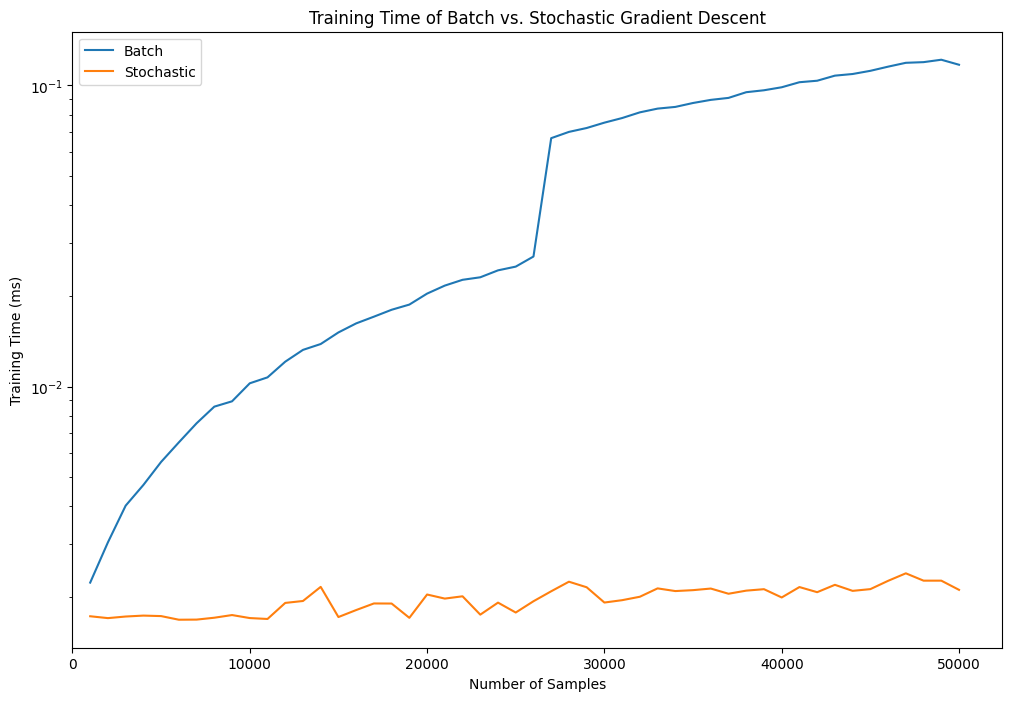

In [182]:
fig, ax = plt.subplots(figsize=(12, 8))
times_data.plot(x='Size', y='Batch', ax=ax, logy=True)
times_data.plot(x='Size', y='Stochastic', ax=ax, logy=True)
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Training Time (ms)')
ax.set_xlim(0)
ax.legend()
ax.set_title('Training Time of Batch vs. Stochastic Gradient Descent')
plt.show()

## Conclusion

It's quite incredible that stochastic gradient descent ran this much faster
than batch gradient descent. Originally, I had expected to see an optimal
point: a crossing of the two curves that indicates the point where batch
gradient descent isn't worth it and stochastic gradient descent becomes a
better option. Instead, it looks like nearly always, stochastic gradient
descent takes the cake.

The most peculiar finding is the sudden jump in training time for batch
gradient descent, at around 26,000 samples. This baffled me for a while, as I
expected a smooth transition of training time as a function of sample size. 
However, after re-running this several times, I kept getting the same result.
After a bit of research, I found some enlightening information.

The jump in training time for batch gradient descent can likely be attributed
to memory allocation. Up through around 26k rows, the arrays neatly fit into
our CPU cache (L2/L3). At around 27k rows, the matrix-vector multiplications
no longer fully fit in the cache, forcing far more frequent main memory access.
This produced a sudden slowdown, requiring a change in the backend algorithm,
ultimately affecting the performance.

While I started this with the intent of understanding batch gradient descent,
it also provided an insightful lesson in the backend nuances of Numpy.